In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
%matplotlib inline
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
import matplotlib.image as img
from itertools import combinations
from scipy.cluster.vq import whiten #Whiten is used to Scale the data

## 1. import image

In [89]:


# Read batman image and print dimensions|

image = img.imread("vangogh-images/1884_still-life-with-two-sacks-and-a-bottle-1884.jpg")
# image = img.imread("1890_rest-work-after-millet-1890.jpg")
# image = img.imread("1890_red-poppies-and-daisies-1890.jpg")
# print("Shape of Image and Arrow is ",image.shape,arrow.shape)

Given Image is ===>


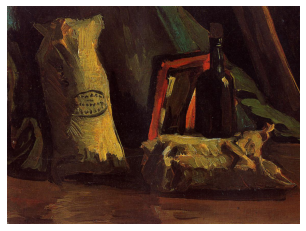

In [90]:
print("Given Image is ===>")
plt.figure()
plt.axis('off')
plt.imshow(image[:,:,:])
plt.show()

## 2. get RGB and scale data

In [91]:
b,r,g=[],[],[]
for row in image:
    # for temp_b, temp_r, temp_g in row:
    for temp_r, temp_g, temp_b in row:
        r.append(int(temp_r))
        g.append(int(temp_g))
        b.append(int(temp_b))

In [92]:
from scipy.cluster.vq import whiten #Whiten is used to Scale the data

scaled_red = whiten(r)
scaled_blue = whiten(b)
scaled_green = whiten(g)

In [93]:
import pandas as pd
df = pd.DataFrame({'red':r,'blue':b,'green':g,'scaled_red':scaled_red,'scaled_blue':scaled_blue,
                   'scaled_green':scaled_green})
df

,red,blue,green,scaled_red,scaled_blue,scaled_green
0,58,50,55,1.396452,2.577393,1.592975
1,94,85,89,2.263216,4.381568,2.577723
2,99,90,94,2.383599,4.639307,2.722539
3,71,62,66,1.709450,3.195967,1.911570
4,74,63,66,1.781680,3.247515,1.911570
...,...,...,...,...,...,...
967563,115,41,58,2.768828,2.113462,1.679865
967564,118,44,61,2.841058,2.268106,1.766754
967565,119,45,62,2.865135,2.319654,1.795717
967566,115,41,58,2.768828,2.113462,1.679865


(array([5.72331e+05, 3.10814e+05, 5.95030e+04, 1.67290e+04, 5.44800e+03,
        1.76600e+03, 6.33000e+02, 2.16000e+02, 1.00000e+02, 2.80000e+01]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

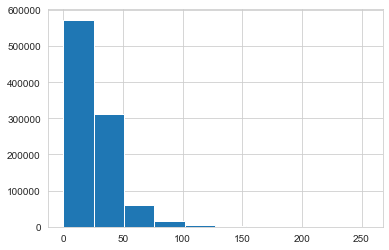

In [94]:
plt.hist(df['blue'])

## 3. K-means cluster to get dominant colors, k=4

In [95]:
# cluster_centers, distortion = KMeans(df[['scaled_red','scaled_blue','scaled_green']],3)
X = df[['scaled_red','scaled_green','scaled_blue']]
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
# print(cluster_centers)

### Elbow Method to find K

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [ ]:

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

### get the dominant color (center of each cluster), stored as RGB

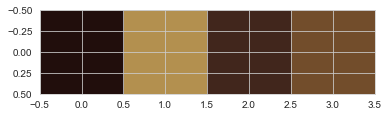

In [96]:
cluster_centers = kmeans.cluster_centers_
dominant_colors = []
red_std, green_std, blue_std = df[['red', 'green', 'blue']].std()

for cluster_center in cluster_centers:
    red_scaled, green_scaled, blue_scaled = cluster_center
    dominant_colors.append((
        int(red_scaled * red_std //1),
    #     blue_scaled * blue_std / 256,
        int(green_scaled * green_std //1),
        int(blue_scaled * blue_std //1)
    ))

    # dominant_colors.append((
    #     # blue_scaled * blue_std / 256,
    #     red_scaled * red_std //1,
    #     green_scaled * green_std //1,
    #     blue_scaled * blue_std //1
    # ))
 
plt.imshow([dominant_colors])
plt.show()

In [97]:
cluster_centers

array([[0.79635997, 0.40961689, 0.66981684],
       [4.31725123, 4.18266195, 4.07980296],
       [1.56610652, 1.11827612, 1.4542024 ],
       [2.75781253, 2.25828263, 2.23893827]])

In [98]:
# color stored as RGB
dominant_colors

[(33, 14, 12), (179, 144, 79), (65, 38, 28), (114, 77, 43)]

## 4. Calculate the average distance of dominant colors

### turn RGB to CIE lab

In [99]:
# RGB to Lab conversion

# Step 1: RGB to XYZ
#         http://www.easyrgb.com/index.php?X=MATH&H=02#text2
# Step 2: XYZ to Lab
#         http://www.easyrgb.com/index.php?X=MATH&H=07#text7


def rgb2lab(inputColor):

    num = 0
    RGB = [0, 0, 0]

    for value in inputColor:
        value = float(value) / 255

        if value > 0.04045:
            value = ((value + 0.055) / 1.055) ** 2.4
        else:
            value = value / 12.92

        RGB[num] = value * 100
        num = num + 1

    XYZ = [0, 0, 0, ]

    X = RGB[0] * 0.4124 + RGB[1] * 0.3576 + RGB[2] * 0.1805
    Y = RGB[0] * 0.2126 + RGB[1] * 0.7152 + RGB[2] * 0.0722
    Z = RGB[0] * 0.0193 + RGB[1] * 0.1192 + RGB[2] * 0.9505
    XYZ[0] = round(X, 4)
    XYZ[1] = round(Y, 4)
    XYZ[2] = round(Z, 4)

    # Observer= 2°, Illuminant= D65
    XYZ[0] = float(XYZ[0]) / 95.047         # ref_X =  95.047
    XYZ[1] = float(XYZ[1]) / 100.0          # ref_Y = 100.000
    XYZ[2] = float(XYZ[2]) / 108.883        # ref_Z = 108.883

    num = 0
    for value in XYZ:

        if value > 0.008856:
            value = value ** (0.3333333333333333)
        else:
            value = (7.787 * value) + (16 / 116)

        XYZ[num] = value
        num = num + 1

    Lab = [0, 0, 0]

    L = (116 * XYZ[1]) - 16
    a = 500 * (XYZ[0] - XYZ[1])
    b = 200 * (XYZ[1] - XYZ[2])

    Lab[0] = round(L, 4)
    Lab[1] = round(a, 4)
    Lab[2] = round(b, 4)

    return Lab


In [100]:
cielab = []
for color in dominant_colors:
    cielab.append(rgb2lab(color))
cielab = np.array(cielab)[:,1:]

In [101]:
cielab

array([[ 8.99  ,  4.1735],
       [ 5.2692, 39.1441],
       [11.4447, 11.9419],
       [11.71  , 26.2001]])

### calculate the distance in the CIElab space

In [102]:
cie_distance = []
for item in combinations(cielab,2):
    cie_distance.append(distance.euclidean(item[0], item[1]))
cie_distance = np.array(cie_distance)
cie_distance.mean()

20.35364103953532